In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from itertools import combinations
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import RFE
from bayes_opt import BayesianOptimization
from sklearn.inspection import PartialDependenceDisplay
from deap import algorithms, base, creator, tools

In [2]:
combined_data=pd.read_excel(r"C:\Users\HP\jupyternotebook\MLofCC\combined_data.xlsx",header=0)

In [3]:
def run_bayesian_optimization(X_train_all, y_train_all):
    def black_box_function(learning_rate, n_estimators, min_samples_split, max_features, max_depth, max_leaf_nodes):
        params = {
            'learning_rate': max(learning_rate, 1e-3),
            'n_estimators': int(n_estimators),
            'min_samples_split': int(min_samples_split),
            'max_features': min(max_features, 0.999),
            'max_depth': int(max_depth),
            'max_leaf_nodes': int(max_leaf_nodes),
            'random_state': 2
        }
        
        model = GradientBoostingRegressor(**params)
        loo = LeaveOneOut()
        preds, truths = [], []
        
        for train_idx, val_idx in loo.split(X_train_all):
            X_train, X_val = X_train_all[train_idx], X_train_all[val_idx]
            y_train, y_val = y_train_all[train_idx], y_train_all[val_idx]
            model.fit(X_train, y_train.ravel())
            preds.append(model.predict(X_val)[0])
            truths.append(y_val[0])
            
        return r2_score(truths, preds)

    pbounds = {
        'learning_rate': (0.001, 0.2),
        'n_estimators': (10, 500),
        'min_samples_split': (2, 25),
        'max_features': (0.1, 1.0),
        'max_depth': (1, 5),
        'max_leaf_nodes': (2, 15)
    }

    optimizer = BayesianOptimization(
        f=black_box_function,
        pbounds=pbounds,
        random_state=1
    )
    optimizer.maximize(init_points=15, n_iter=20)
    return optimizer.max['params']

In [4]:
data=pd.read_excel(r"C:\Users\HP\Desktop\Data.xlsx",sheet_name='16+3',index_col=0,header=0)
data1=data.iloc[0:18, :]
scaler = preprocessing.MinMaxScaler()
feature_columns = ['lg(O3)', 'lg(H2O2)', 'pH']
scaler.fit(data1[feature_columns])
min_value = scaler.data_min_
max_value = scaler.data_max_
min_H2O2=min_value[1]
min_O3=min_value[0]
min_pH=min_value[2]
max_H2O2=max_value[1]
max_O3=max_value[0]
max_pH=max_value[2]

In [5]:
X_final = scaler.transform(combined_data[['lg(O3)', 'lg(H2O2)', 'pH']])
y_final = combined_data['TOC'].values.reshape(-1, 1)
best_params = run_bayesian_optimization(X_final, y_final)
final_model = GradientBoostingRegressor(learning_rate=best_params['learning_rate'],
        n_estimators=int(best_params['n_estimators']),
        min_samples_split=int(best_params['min_samples_split']),
        max_features=best_params['max_features'],
        max_depth=int(best_params['max_depth']),
        max_leaf_nodes=int(best_params['max_leaf_nodes']),
        random_state=2)
final_model.fit(X_final, y_final.ravel())

|   iter    |  target   | learni... | max_depth | max_fe... | max_le... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.7123    | 0.08399   | 3.881     | 0.1001    | 5.93      | 5.375     | 55.25     |
| 2         | 0.6995    | 0.03807   | 2.382     | 0.4571    | 9.005     | 11.64     | 345.8     |
| 3         | 0.7393    | 0.04169   | 4.512     | 0.1246    | 10.72     | 11.6      | 283.8     |
| 4         | 0.645     | 0.02894   | 1.792     | 0.8207    | 14.59     | 9.209     | 349.2     |
| 5         | 0.6726    | 0.1754    | 4.578     | 0.1765    | 2.508     | 5.906     | 440.3     |
| 6         | 0.6278    | 0.02057   | 2.684     | 0.9621    | 8.931     | 17.91     | 164.6     |
| 7         | 0.6826    | 0.1376    | 4.339     | 0.1165    | 11.75     | 24.74     | 376.6     |
| 8         | 0.7102    | 0.05681   | 4.157     | 0.1929    | 7.823     | 22.9      | 153.9     |
| 9         | 0.6179

GradientBoostingRegressor(learning_rate=0.049046689099860485, max_depth=4,
                          max_features=0.1312327831379522, max_leaf_nodes=10,
                          min_samples_split=11, n_estimators=283,
                          random_state=2)

In [8]:
def calculate_cost(lgO3, lgH2O2, pH, TOC):

    O3_conc = 10**lgO3
    H2O2_conc = 10**lgH2O2
    
    base_cost = (H2O2_conc * 120 / 1000 * 0.00655) + (O3_conc * 1.2 / 1000 * 0.477)
    
    if pH < 9.2:
        delta = (0.71571 - 0.2908*pH + 0.0438*pH**2 - 0.00224*pH**3) * 0.7084 * 0.001
    elif pH > 9.2:
        delta = (-10.6235 + 1.89296*pH - 0.08022*pH**2) * 0.001 * 0.2 * 3.683
    else:
        delta = 0
    
    total_cost = base_cost + delta
    normalized_cost = total_cost / (0.24 * TOC * 0.3 * 0.001)
    return normalized_cost

def evaluate(individual):

    assert len(individual) == 3, f"Invalid individual length: {len(individual)}"
    
    individual_array = np.array(individual).reshape(1, -1)
    scaled_params = scaler.inverse_transform(individual_array)[0]
    lgO3, lgH2O2, pH = scaled_params
    
    TOC = final_model.predict(individual_array)[0]
    
    cost = calculate_cost(lgO3, lgH2O2, pH, TOC)
    
    return (cost, TOC)

gen	nevals
0  	200   
1  	200   
2  	200   
3  	200   
4  	200   
5  	200   
6  	200   
7  	200   
8  	200   
9  	200   
10 	200   
11 	200   
12 	200   
13 	200   
14 	200   
15 	200   
16 	200   
17 	200   
18 	200   
19 	200   
20 	200   
21 	200   
22 	200   
23 	200   
24 	200   
25 	200   
26 	200   
27 	200   
28 	200   
29 	200   
30 	200   
31 	200   
32 	200   
33 	200   
34 	200   
35 	200   
36 	200   
37 	200   
38 	200   
39 	200   
40 	200   
41 	200   
42 	200   
43 	200   
44 	200   
45 	200   
46 	200   
47 	200   
48 	200   
49 	200   
50 	200   
51 	200   
52 	200   
53 	200   
54 	200   
55 	200   
56 	200   
57 	200   
58 	200   
59 	200   
60 	200   
61 	200   
62 	200   
63 	200   
64 	200   
65 	200   
66 	200   
67 	200   
68 	200   
69 	200   
70 	200   
71 	200   
72 	200   
73 	200   
74 	200   
75 	200   
76 	200   
77 	200   
78 	200   
79 	200   
80 	200   
81 	200   
82 	200   
83 	200   
84 	200   
85 	200   
86 	200   
87 	200   
88 	200   
89 	200   

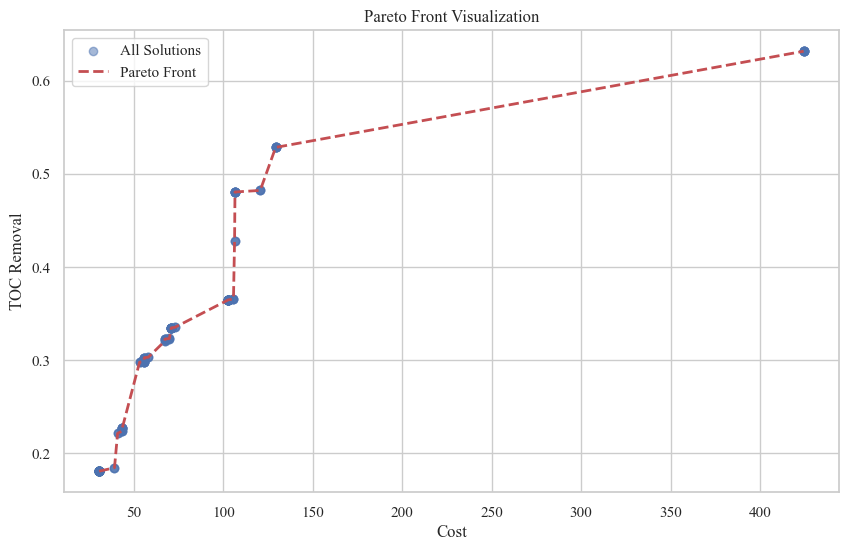

Pareto Front Solutions:
      lg(O3)  lg(H2O2)        pH        Cost       TOC
40 -0.215114 -1.873544  7.584323   30.441807  0.180881
63 -0.215114 -1.873544  7.584323   30.441807  0.180881
62 -0.215114 -1.873544  7.584323   30.441807  0.180881
61 -0.215114 -1.873544  7.584323   30.441807  0.180881
60 -0.215114 -1.873544  7.584323   30.441807  0.180881
..       ...       ...       ...         ...       ...
21  0.728792  0.362152  7.280614  129.176674  0.528400
97  0.729394  1.313869  7.164425  424.443051  0.631598
98  0.729394  1.313869  7.164425  424.443051  0.631598
96  0.729394  1.313869  7.164425  424.443051  0.631598
99  0.729394  1.313869  7.164425  424.443051  0.631598

[145 rows x 5 columns]


In [9]:
min_max_values = {
    'lg(O3)': (min_O3, max_O3),  
    'lg(H2O2)': (min_H2O2, max_H2O2),
    'pH': (min_pH, max_pH)
}

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0)) 
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()


BOUNDS_LOW = [0, 0, 0]  
BOUNDS_HIGH = [1, 1, 1]  

def generate_parameter(index):
    return np.random.uniform(BOUNDS_LOW[index], BOUNDS_HIGH[index])

toolbox.register("attr_0", generate_parameter, 0)  # lg(O3)
toolbox.register("attr_1", generate_parameter, 1)  # lg(H2O2)
toolbox.register("attr_2", generate_parameter, 2)  # pH

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_0, toolbox.attr_1, toolbox.attr_2), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def check_bounds(min, max):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for child in offspring:
                for i in range(len(child)):
                    child[i] = np.clip(child[i], min[i], max[i])
            return offspring
        return wrapper
    return decorator


toolbox.register("mate", tools.cxSimulatedBinary, eta=20)
toolbox.decorate("mate", check_bounds(BOUNDS_LOW, BOUNDS_HIGH)) 

toolbox.register("mutate", tools.mutPolynomialBounded, 
                eta=15, indpb=0.1, 
                low=BOUNDS_LOW, up=BOUNDS_HIGH)



toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selNSGA2)

def main():
    pop_size = 200
    ngen = 200
    pop = toolbox.population(n=pop_size)
    algorithms.eaMuPlusLambda(pop, toolbox, 
                             mu=pop_size, 
                             lambda_=pop_size,
                             cxpb=0.85, 
                             mutpb=0.15, 
                             ngen=ngen, 
                             verbose=True)
    return pop

final_pop = main()

def process_results(population):
    results = []
    for ind in population:
        if not ind.fitness.valid:
            continue

        scaled_params = scaler.inverse_transform([ind])[0]
        cost, toc = ind.fitness.values
        results.append({
            'lg(O3)': scaled_params[0],
            'lg(H2O2)': scaled_params[1],
            'pH': scaled_params[2],
            'Cost': cost,
            'TOC': toc
        })
    return pd.DataFrame(results)

df_results = process_results(final_pop)
pareto_front = tools.sortNondominated(final_pop, len(final_pop), first_front_only=True)[0]

plt.figure(figsize=(10, 6))
plt.scatter(df_results['Cost'], df_results['TOC'], c='b', alpha=0.5, label='All Solutions')
pareto_df = process_results(pareto_front)
pareto_df = pareto_df.sort_values('Cost')
plt.plot(pareto_df['Cost'], pareto_df['TOC'], 'r--', linewidth=2, label='Pareto Front')
plt.xlabel('Cost')
plt.ylabel('TOC Removal')
plt.title('Pareto Front Visualization')
plt.legend()
plt.grid(True)
plt.show()

print("Pareto Front Solutions:")
print(pareto_df.sort_values('Cost'))